In [1]:
import numpy as np
import scipy as sp
from scipy.constants import mu_0
import matplotlib.pyplot as plt
from collections import namedtuple
import matplotlib
from scipy.optimize import fmin, root
from mpl_toolkits.axes_grid1 import make_axes_locatable
grav_accel_mps2 = 9.81

%matplotlib inline

# some setting for the plots
font = {
#     'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('lines', linewidth=2)
matplotlib.rc('font', **font)


## Define parameters

In [2]:
parameters = {
    'Br': 0.73, # magnet remnant magnetization in T
    'density': 7600, # magnet density in kg/m^3
    'grav_accel': 9.81, # gravitational acceleration in m/s^2
    'muo':4*np.pi*1e-7, # vacuum permability in H/m
    'a':0
}

## Define functions

In [50]:
## plotting the function hcool


# levitation height for type I

def critical_radius(Br, density, grav_accel, muo):
    """
    
    returns: critical radius in meters
    """
    acrit = (Br**2 / (16*grav_accel*density*muo))
    return acrit
   
def lev_height_type_I(a, parameters):
    """
    parameters: dictionary containing Br, density, grav_accel, muo
    a: particle radius in meters
    returns: critical radius in meters
    """
    Br, density, grav_accel, muo = parameters['Br'], parameters['density'], parameters['grav_accel'], parameters['muo']
    acrit = critical_radius(Br, density, grav_accel, muo)
    hI = acrit**(1/4) * a**(3/4)
    return hI


def potential_no_units(z, theta, h_cool, theta_cool):
    
    """
    potential where x=y=phi=0 and theta and z are still free parameters
    
    z : height of magnet above SC in units of type I levitation height  (see lev_height_type_I )
    theta : angle of levitated magnet in radians
    h_cool: height of magnetabove SC  during cooldown in units of type I levitation height  (see lev_height_type_I ), theta_cool
    theta_cool: angle of magnet during cooldown in radians
    """

    
    return z+1/6 * (3+np.cos(2*theta))/z**3 - 8/3 * (3*np.cos(theta-theta_cool)+np.cos(theta+theta_cool)) / (h_cool+z)**3
    
    
def find_equilibrium(h_cool, theta_cool, tol=1e-6, max_attempts = 5, verbose = False):
    """
    find the equilibrium height and angle for a given cool down height and angle
    
    h_cool: cool down height normalized to hI (eq. height in Meissner state)
    theta_cool: cool down angle (in radians)
    
    """

    def fun(x, *args):  
        z, theta = x
        h_cool, theta_cool = args
        return potential_no_units(z, theta, h_cool, theta_cool)

    
    if not hasattr(h_cool, '__len__'):
        is_scalar = True
        h_cool = [h_cool]
        theta_cool = [theta_cool]
        shape = None
    else:
        is_scalar = False
        shape = np.shape(h_cool)
        assert np.shape(h_cool) == np.shape(theta_cool) # have to be the same shape
        h_cool = np.array(h_cool).flatten()
        theta_cool = np.array(theta_cool).flatten()
    
    equilibrium_position = []
    for hc, tc in zip(h_cool, theta_cool): 
    
        hc_init = h_eq_pi_over_2(hc)

        if hc>1:
            theta_init = np.pi/2 # if cooled far from SC, the angle will relax to pi/2
        else:
            theta_init = tc # if cooled near SC, the angle gets frozen in 

        xo = hc_init, theta_init

        # run optimization
        eq = sp.optimize.minimize(fun, xo, args = (hc, tc), tol=tol,method='TNC', bounds= [(0, 2*hc), (0, 2*np.pi)])

        equilibrium_position.append(eq['x'])
    if verbose and is_scalar:
        print(eq)
        
    if is_scalar:
        equilibrium_position = equilibrium_position[0]
    else:
        equilibrium_position = [np.reshape(np.array(equilibrium_position)[:, 0], shape),
                                np.reshape(np.array(equilibrium_position)[:, 1], shape)]
                                
    return equilibrium_position


def h_cool_pi_over_2(z):
    """
    z: equilibrium height in units of hI (equilibirum height in Meissner state)
    
    implements the function cooldown height as a function of equilibrium height with normalized units
    to get the physical units scale by hI (equilibirum height in Meissner state)
    """

    
    return z*(2/(1-z**4)**(1/4)-1)

def h_eq_pi_over_2(h_cool):
    """
    h_cool: cool down height for type II in units of hI (equilibirum height in Meissner state) for the special case where theta_cool  = pi/2
    
    implements the function equilibrium height as a function of cooldown height with normalized units
    to get the physical units scale by hI (equilibirum height in Meissner state)
    """
    
    def fun(x, hc):
        return h_cool_pi_over_2(x)-hc
        
    if hasattr(h_cool, '__len__'):
        assert len(h_cool) # check if h_cool is an array type object, i.e. it has a length
        result = [sp.optimize.brenth(fun, 0, 1-1e-7, args = (hc)) for hc in h_cool]
    else:
        result = sp.optimize.brenth(fun, 0, 1-1e-7, args = (h_cool))
    
    return result


In [51]:
h_cool = [0.2, 0.3]
theta_cool = [0.5, 0.3]

for hc, tc in zip(h_cool, theta_cool):
    print(hc, tc)
find_equilibrium(h_cool, theta_cool)
find_equilibrium(h_cool[0], theta_cool[0])

0.2 0.5
0.3 0.3


array([ 0.19990356,  0.50025084])

## plot the potential and the equilbirum position for a single cool down height and angle

     fun: 0.65417030932615172
     jac: array([  2.22044605e-08,   0.00000000e+00])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 21
     nit: 9
  status: 1
 success: True
       x: array([ 0.94451889,  0.        ])


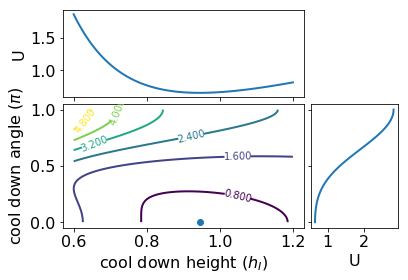

In [108]:
# set the initial conditions
theta_cool = 0
# theta_cool = np.pi/2
h_cool = 1.2


# find equilibrium
h_eq, theta_eq = find_equilibrium(h_cool, theta_cool, tol=1e-10, verbose=True)
# calculate the potential
z = np.linspace(0.6, max([0.9, h_cool]), 100)
theta = np.linspace(0,np.pi, 100)
X, Y = np.meshgrid(z, theta)
Z = potential_no_units(X, Y, h_cool, theta_cool)

# create figure
fig, axContour = plt.subplots() #figsize=(5.5, 5.5)

# plot contour
CS =plt.contour(X, Y/np.pi, Z)
axContour.clabel(CS, inline=1, fontsize=10)
axContour.plot(h_eq, theta_eq/np.pi, 'o')
axContour.set_xlabel('cool down height ($h_I$)')
axContour.set_ylabel('cool down angle ($\pi$)')

# # the scatter plot:
# axScatter.scatter(x, y)
# axScatter.set_aspect(1.)

# create new axes on the right and on the top of the current axes
# The first argument of the new_vertical(new_horizontal) method is
# the height (width) of the axes to be created in inches.
divider = make_axes_locatable(axContour)
axCrosssectionx = divider.append_axes("top", 1.2, pad=0.1, sharex=axContour)
axCrosssectiony = divider.append_axes("right", 1.2, pad=0.1, sharey=axContour)

# make some labels invisible
plt.setp(axCrosssectionx.get_xticklabels() + axCrosssectiony.get_yticklabels(),
         visible=False)

# calculate and plot the horizontal cross section
Uh = potential_no_units(z, theta_eq, h_cool, theta_cool)
axCrosssectionx.plot(z, Uh)
axCrosssectionx.set_ylabel('U')

# # calculate and plot the vertical cross section
Uv = potential_no_units(h_eq, theta, h_cool, theta_cool)
axCrosssectiony.plot(Uv, theta/np.pi)
axCrosssectiony.set_xlabel('U')

plt.draw()
plt.show()

## plot the potential and the equilbirum position for all possible cool down heights and angles

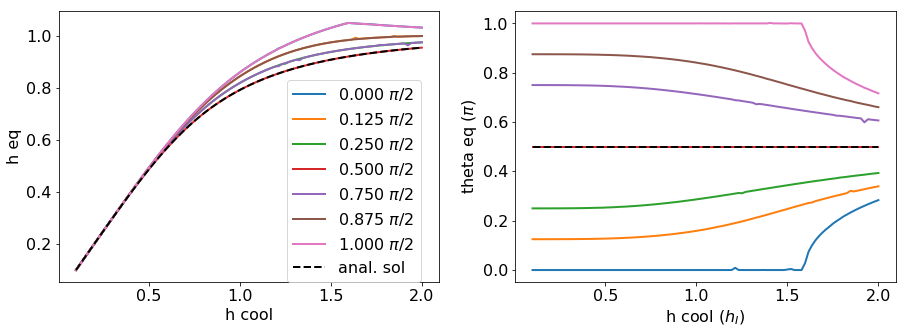

In [113]:
h_cool = np.linspace(0.1, 2, 100)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

for theta_cool in [0, 0.25*np.pi/2, 0.5*np.pi/2, np.pi/2, 1.5*np.pi/2, 1.75*np.pi/2, 2*np.pi/2]:
    data = []
    for h in h_cool:
        data.append(find_equilibrium(h, theta_cool))
    data = np.array(data)


    ax1.plot(h_cool, data[:,0], label = '{:0.3f} $\pi/2$'.format(theta_cool/np.pi))
    ax2.plot(h_cool, data[:,1]/np.pi, label = '{:0.3f} $\pi/2$'.format(theta_cool/np.pi))
    
ax1.plot(h_cool, h_eq_pi_over_2(h_cool), 'k--', label = 'anal. sol')
ax2.plot(h_cool, 0.5* np.ones(len(h_cool)), 'k--', label = 'anal. sol')
ax1.set_xlabel('h cool')
ax1.set_ylabel('h eq')
ax1.legend(loc = (0.6,0))

ax2.set_xlabel('h cool ($h_I$)')
ax2.set_ylabel('theta eq ($\pi$)')
# ax2.legend(loc = (1,0))
f.savefig('equilibirum_position_cross_cut.pdf')

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars
/Applications/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


Text(0.5,1,'equilibrium angle ($\\pi$)')

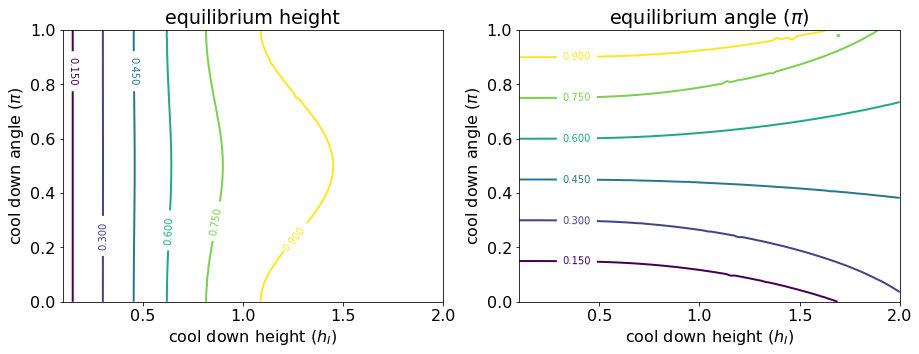

In [111]:
# calculate the potential
h_cool = np.linspace(0.1, 2, 100)
theta_cool = np.linspace(0,np.pi, 100)
X, Y = np.meshgrid(h_cool, theta_cool)

h_eq, theta_eq = find_equilibrium(X, Y)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey =False)

# fig, axContour = plt.subplots() #figsize=(5.5, 5.5)
CS =ax1.contour(X, Y/np.pi, h_eq)
ax1.clabel(CS, inline=1, fontsize=10)
ax1.set_xlabel('cool down height ($h_I$)')
ax1.set_ylabel('cool down angle ($\pi$)')
ax1.set_title('equilibrium height')

CS =ax2.contour(X, Y/np.pi, theta_eq/np.pi)
ax2.clabel(CS, inline=1, fontsize=10)
ax2.set_xlabel('cool down height ($h_I$)')
ax2.set_ylabel('cool down angle ($\pi$)')
ax2.set_title('equilibrium angle ($\pi$)')

In [112]:
f.savefig('equilibirum_position_contour.pdf')

## Calculate the frequencies

In [220]:
parameters = {
    'Br': 0.73, # magnet remnant magnetization in T
    'density': 7600, # magnet density in kg/m^3
    'grav_accel': 9.81, # gravitational acceleration in m/s^2
    'muo':4*np.pi*1e-7, # vacuum permability in H/m
    'a':0
}


def spring_constant_z_FC(a, Br, h_cool, muo):
    return np.pi/6 * a**6*Br**2 / (h_cool**5*muo)
   
    
def mass_sphere(a, rho):
    return 3*np.pi/4 * a**3*rho

def inertia_sphere(a, rho):
    return 2/5*a**2*mass_sphere(a, rho)

def linearized_potential_matrix(a, Br, h_cool, theta_cool, muo):
    """
    returns a matrix A_U with the linearized spring and coupling constants
    
    to get the linearized potential calculate u^T A_U u, where u is the state vector with u = (x, y, z, theta, phi)
    
    
    """
    
    cs = np.cos(2*theta_cool)
    sn = np.sin(2*theta_cool)
    hc = h_cool
    
    A_u = np.array([[1/8*(7+cs), 0, 0, -hc, 0],
                    [0, 1/8*(5+3*cs), 0, 0, -hc/2*sn],
                    [0,0,1/2*(3+cs), hc/2*sn, 0],
                    [-hc, 0, hc/2*sn, hc**2/6*(3-cs), 0],
                    [0, -hc/2*sn, 0, 0, hc**2/6*(1-cs)]])
    
    kz = spring_constant_z_FC(a, Br, h_cool, muo)
    return kz * A_u/2


def get_frequencies(a, h_cool, theta_cool, parameters):
    """
    calculates the frequencies based on the diagonal of A_u! shoud be changed to the eigenfrequencies!!
    """


    A_u = linearized_potential_matrix(a, parameters['Br'], h_cool, theta_cool, parameters['muo'])
    # def frequencies(a, Br, h_cool, theta_cool, muo):
    rho = parameters['density']
    m = mass_sphere(a, rho)
    Io = inertia_sphere(a, rho)
    freq = np.sqrt(np.concatenate([
        np.diagonal(A_u)[0:3] / m,
        np.diagonal(A_u)[3:5] / Io])) / (2* np.pi)
    return freq
    
    
def get_eigenfrequencies(a, h_cool, theta_cool, parameters):
    """
    calculates the frequencies based on the diagonal of A_u! shoud be changed to the eigenfrequencies!!
    """

    m = mass_sphere(a, rho)
    A_u = 2*linearized_potential_matrix(a, parameters['Br'], h_cool, theta_cool, parameters['muo'])
    Minv = 1/m * np.diag([1,1,1,5/2,5/2]) # inverse mass matrix
    
    A = np.dot(Minv, A_u)
#     # def frequencies(a, Br, h_cool, theta_cool, muo):
#     rho = parameters['density']
#     
#     Io = inertia_sphere(a, rho)
#     freq = np.sqrt(np.concatenate([
#         np.diagonal(A_u)[0:3] / m,
#         np.diagonal(A_u)[3:5] / Io])) / (2* np.pi)

    freqs, eigv = np.linalg.eig(A)
    return freqs, eigv
    
h_cool = 100e-6
a = 30e-6
theta_cool = np.pi/2
freqs, eigv = get_eigenfrequencies(a, h_cool, theta_cool, parameters)
freqs0 = get_frequencies(a, h_cool, theta_cool, parameters)
np.sqrt(freqs), freqs0

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in sqrt


(array([  5.01091918e+03,              nan,   5.78611095e+03,
          2.89305548e+03,   5.28197248e-01]),
 array([  563.92652501,   325.58313102,   651.16626203,  2802.17343162,
         1981.43583556]))

In [209]:
a = np.array([[1, 0], [0, 1]])
b = np.array([[4, 1], [2, 2]])
print(a)
print(b)
print(np.dot(a, b))

[[1 0]
 [0 1]]
[[4 1]
 [2 2]]
[[4 1]
 [2 2]]


### frequencies as a function of particle size (cool down height = 3 x a')

In [172]:
a_array = np.linspace(0.1e-6, 100e-6, 100)

freqs = np.array([get_frequencies(a, 3*a, theta_cool, parameters) for a in a_array])

Text(0.5,1,'cool down height = 3 x a')

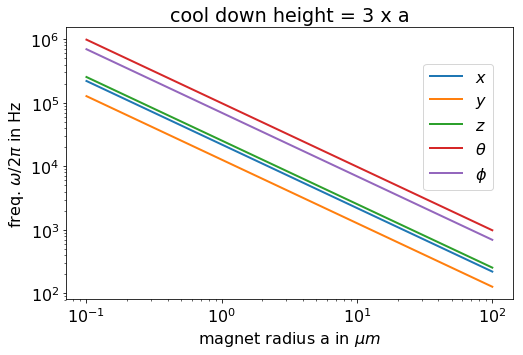

In [176]:
f, (ax1) = plt.subplots(1, 1, figsize=(8,5), sharey =False)
labels = ['$x$', '$y$', '$z$', '$\\theta$', '$\phi$']
for freq, l in zip(freqs.T, labels):
    ax1.loglog(a_array*1e6, freq, label = l)
ax1.set_xlabel('magnet radius a in $\mu m$')
ax1.set_ylabel('freq. $\omega / 2\pi$ in Hz')
ax1.legend(loc = (0.8,0.4))
ax1.set_title('cool down height = 3 x a')

In [177]:
f.savefig('frequencies_type_II2_cooldown_3x_a.pdf')

### frequencies as a function of cool down angle (cool down height = 3 x a, a = 30um)

In [182]:
a = 30e-6

theta_array = np.linspace(0, np.pi, 100)

freqs = np.array([get_frequencies(a, 3*a, theta_cool, parameters) for theta_cool in theta_array])

Text(0.5,1,'cool down height = 3 x a, a = 30 $\\mu m$')

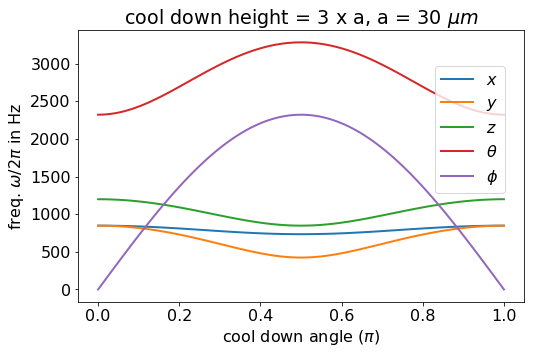

In [191]:
f, (ax1) = plt.subplots(1, 1, figsize=(8,5), sharey =False)
labels = ['$x$', '$y$', '$z$', '$\\theta$', '$\phi$']
for freq, l in zip(freqs.T, labels):
    ax1.plot(theta_array/np.pi, freq, label = l)
ax1.set_xlabel('cool down angle ($\pi$)')
ax1.set_ylabel('freq. $\omega / 2\pi$ in Hz')
ax1.legend(loc = (0.8,0.4))
ax1.set_title('cool down height = 3 x a, a = 30 $\mu m$')

In [192]:
f.savefig('frequencies_type_II2_cooldown_3x_30um_angle_depenency.pdf')

### frequencies as a function of cool down height (cool down angle = \pi/2, a = 30um)

In [195]:
a = 30e-6
theta_cool = np.pi/2
h_factor_array = np.linspace(2, 5, 100)

freqs = np.array([get_frequencies(a, h_factor*a, theta_cool, parameters) for h_factor in h_factor_array])

Text(0.5,1,'cool down angle = $\\pi/2$, a = 30 $\\mu m$')

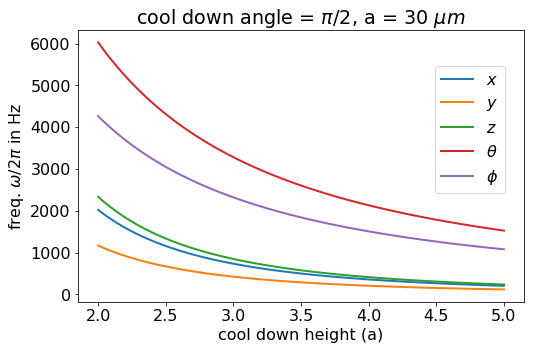

In [199]:
f, (ax1) = plt.subplots(1, 1, figsize=(8,5), sharey =False)
labels = ['$x$', '$y$', '$z$', '$\\theta$', '$\phi$']
for freq, l in zip(freqs.T, labels):
    ax1.plot(h_factor_array, freq, label = l)
ax1.set_xlabel('cool down height (a)')
ax1.set_ylabel('freq. $\omega / 2\pi$ in Hz')
ax1.legend(loc = (0.8,0.4))
ax1.set_title('cool down angle = $\pi/2$, a = 30 $\mu m$')

In [200]:
f.savefig('frequencies_type_II2_cooldown_3x_30um_height_depenency.pdf')